Optimization progress:
Step  1: Energy = -11399.96, Cuts = 11.4
Step  2: Energy = -11332.56, Cuts = 11.3
Step  3: Energy = -11540.06, Cuts = 11.4
Step  4: Energy = -11379.93, Cuts = 11.2
Step  5: Energy = -11432.57, Cuts = 11.8
Step  6: Energy = -11287.10, Cuts = 11.3
Step  7: Energy = -11299.22, Cuts = 11.1
Step  8: Energy = -11136.75, Cuts = 11.0
Step  9: Energy = -8017.23, Cuts = 7.6
Step 10: Energy = -10358.26, Cuts = 9.7


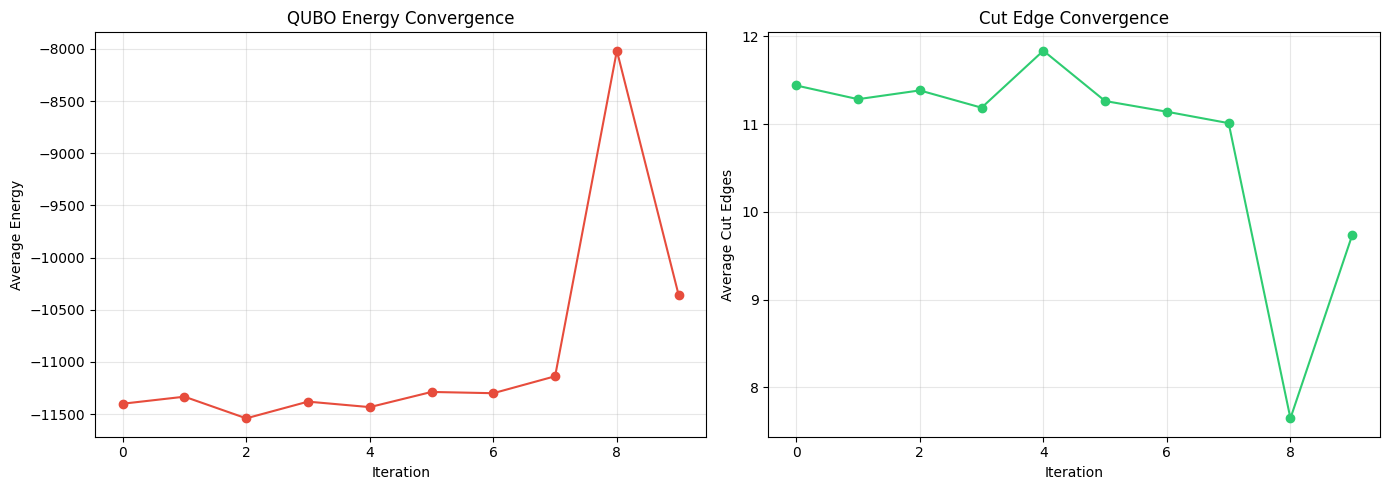

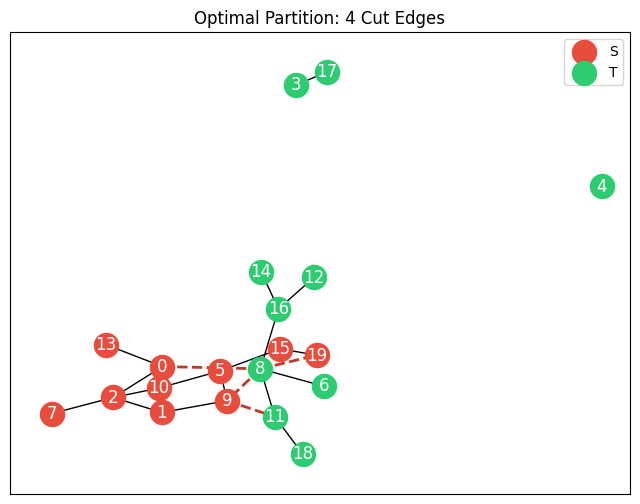

In [ ]:
import networkx as nx
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as qnp

#Defining The Graph:
n = 20  
p = 0.1 
G = nx.erdos_renyi_graph(n, p, seed=42, directed=False)
for u, v in G.edges():
    G[u][v]['weight'] = 1 

#QUBO:
def build_balanced_qubo(G, balance_strength=5):
    n = G.number_of_nodes()
    Q = np.zeros((n, n))
    # Minimize cut edges
    for u, v in G.edges():
        Q[u][u] += 1
        Q[v][v] += 1
        Q[u][v] -= 2
    # Balance constraint
    P = balance_strength * (G.size() + 1)
    for i in range(n):
        Q[i][i] += P * (1 - n)
        for j in range(n):
            if i != j: Q[i][j] += P
    return Q

Q = build_balanced_qubo(G)

# 3.QAOA Setup:
num_qubits = n
p_layers = 2
shots = 1000
dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

def qaoa_layer(gamma, beta):
    # Problem Hamiltonian
    for i in range(n):
        for j in range(i+1, n):
            if Q[i][j] != 0:
                qml.IsingZZ(2 * gamma * Q[i][j], wires=[i, j])
    # Mixer Hamiltonian
    for i in range(n):
        qml.RX(2 * beta, wires=i)

@qml.qnode(dev)
def circuit(params):
    for wire in range(n): qml.Hadamard(wires=wire)
    gammas, betas = params[:p_layers], params[p_layers:]
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(gamma, beta)
    return qml.sample()

# 4.Parameters
params = qnp.concatenate([
    qnp.zeros(p_layers),  # gamma = 0
    qnp.full(p_layers, np.pi/2)  # beta = π/2
])
best_params = params.copy()
best_energy = float('inf')
energy_history = []
cut_history = []

#Optimization:
opt = qml.SPSAOptimizer(maxiter=10)

print("Optimization progress:")
for step in range(10):
    samples = circuit(params)
    
    energies = []
    cut_sizes = []
    
    for bitstr in samples:
        x = bitstr.astype(int)
        
        #Energy Calculation:
        energies.append(x @ Q @ x)
        
        # Cut Edge Calculation:
        cut = 0
        for u, v in G.edges():
            if x[u] != x[v]:
                cut += 1
        cut_sizes.append(cut)
    
    avg_energy = np.mean(energies)
    avg_cut = np.mean(cut_sizes)
    
    energy_history.append(avg_energy)
    cut_history.append(avg_cut)
    
    if avg_energy < best_energy:
        best_energy, best_params = avg_energy, params.copy()
    
    params = opt.step(lambda p: np.mean([x @ Q @ x for x in circuit(p).astype(int)]), params)
    
    print(f"Step {step+1:2d}: Energy = {avg_energy:.2f}, Cuts = {avg_cut:.1f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(energy_history, marker='o', color='#e74c3c')
ax1.set_title("QUBO Energy Convergence")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Average Energy")
ax1.grid(True, alpha=0.3)

ax2.plot(cut_history, marker='o', color='#2ecc71')
ax2.set_title("Cut Edge Convergence")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Average Cut Edges")
ax2.grid(True, alpha=0.3)
plt.tight_layout()

final_samples = circuit(best_params)
balanced_candidates = [
    x.astype(int) for x in final_samples 
    if abs(np.sum(x) - n/2) <= 1
]

if not balanced_candidates:
    raise ValueError("No balanced partitions found!")

energies = [c @ Q @ c for c in balanced_candidates]
optimal_partition = balanced_candidates[np.argmin(energies)]

S = np.where(optimal_partition == 1)[0].tolist()
T = np.where(optimal_partition == 0)[0].tolist()
cut_edges = [(u, v) for u, v in G.edges() if (u in S and v in T) or (u in T and v in S)]

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, nodelist=S, node_color='#e74c3c', label='S')
nx.draw_networkx_nodes(G, pos, nodelist=T, node_color='#2ecc71', label='T')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='#c0392b', width=2, style='dashed')
nx.draw_networkx_edges(G, pos, edgelist=list(set(G.edges())-set(cut_edges)))
nx.draw_networkx_labels(G, pos, font_color='white')
plt.legend()
plt.title(f"Optimal Partition: {len(cut_edges)} Cut Edges")
plt.show()